In [69]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preparação

In [70]:
us_change = pd.read_csv("data/us_change.csv")
us_change
forecast_steps = 20

data = us_change["Consumption"][:-forecast_steps]
covariables = us_change[["Income", "Production", "Savings", "Unemployment"]][:-forecast_steps]

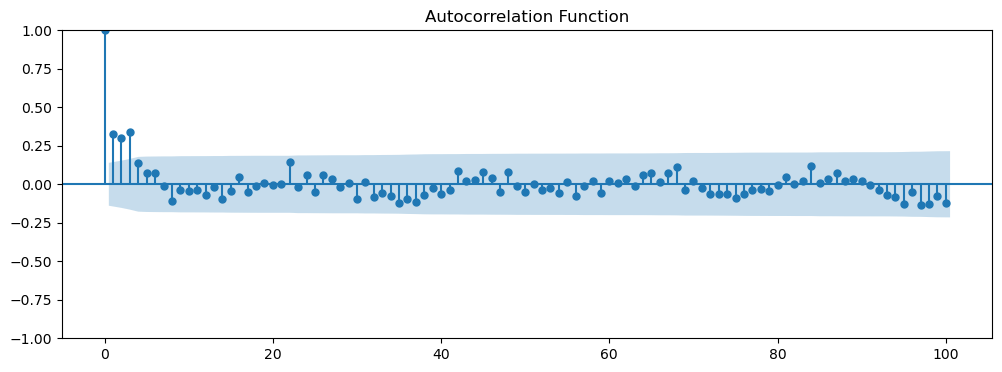

In [71]:
# ACF plot
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(us_change["Consumption"], lags=100, ax=ax)
plt.title('Autocorrelation Function')
plt.show()

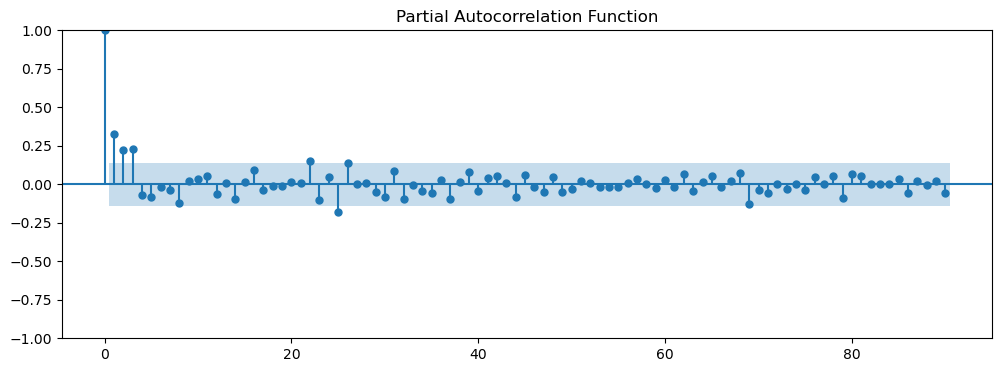

In [72]:
# PACF plot
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(us_change["Consumption"], lags=90, method='ywm', ax=ax)  # Use `ywm` or `ols` for consistent results
plt.title('Partial Autocorrelation Function')
plt.show()

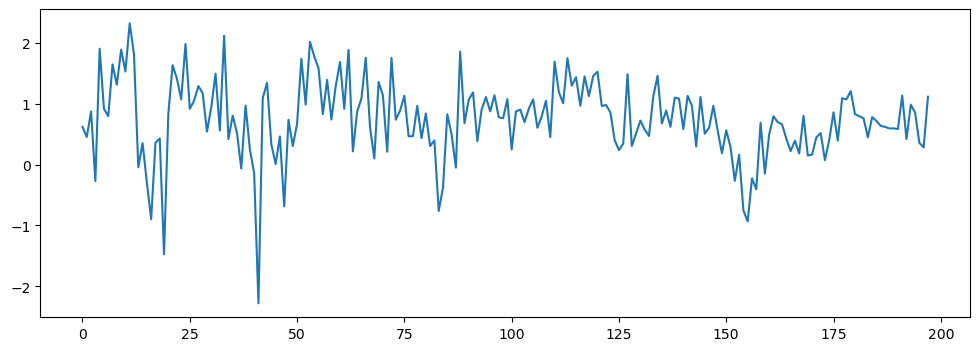

In [73]:
plt.figure(figsize=(12,4))
plt.plot(us_change["Consumption"])

## SARIMA

In [ ]:
model = SARIMAX(data)
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08011D+00    |proj g|=  4.89565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   1.430D-07   1.080D+00
  F =   1.0801054046968313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


### Residuals

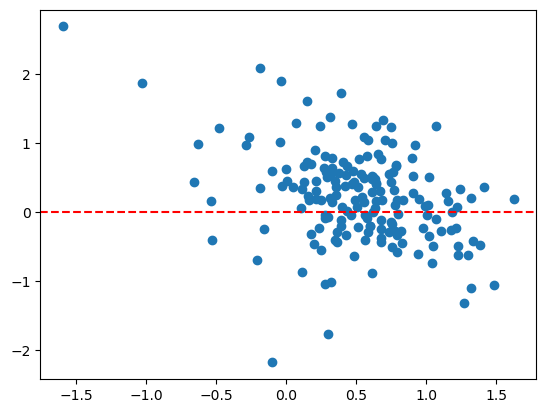

In [75]:
plt.scatter(model_fit.fittedvalues, model_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [76]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  42.823818   0.000005


Resíduos estão bastante correlacionados

## SARIMAX

In [77]:
model_x = SARIMAX(data, exog=covariables)
model_x_fit = model_x.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99519D-01    |proj g|=  5.41887D-01

At iterate    5    f=  3.98734D-01    |proj g|=  2.38874D-01

At iterate   10    f=  3.98335D-01    |proj g|=  1.21366D-01

At iterate   15    f=  3.98034D-01    |proj g|=  9.98015D-02

At iterate   20    f=  3.97820D-01    |proj g|=  5.42679D-03

At iterate   25    f=  3.97777D-01    |proj g|=  2.93098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


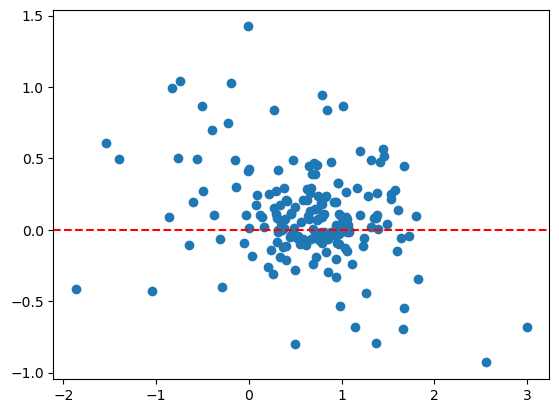

In [78]:
plt.scatter(model_x_fit.fittedvalues, model_x_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [79]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(model_x_fit.resid, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  17.404502   0.065879


Resíduos ainda estão correlacionados, bem menos.

# Métricas

In [85]:
# Previsões dentro do período ajustado

fitted_values_sarima = model_fit.fittedvalues
fitted_values_sarimax = model_x_fit.fittedvalues

# Previsões fora do período ajustado (exemplo: 20 passos à frente)
forecast_sarima = model_fit.forecast(steps=forecast_steps)
forecast_sarimax = model_x_fit.forecast(steps=forecast_steps, exog=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:])

### Sarima

In [86]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarima)

# MSE
mse = mean_squared_error(data, fitted_values_sarima)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarima) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarima)

# AIC
aic = model_fit.aic

# BIC
bic = model_fit.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.545556208779702
MSE: 0.5069356162090081
RMSE: 0.711994112481984
MAPE: 119.12206090126836%
R²: -0.14497707321829312
AIC: 388.5175240720719
BIC: 394.8810911726561


In [87]:
# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_sarima)
mse_outsample = mean_squared_error(real_values, forecast_sarima)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.6109176084474851, MSE: 0.4307167889826967


### Sarimax

In [88]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarimax)

# MSE
mse = mean_squared_error(data, fitted_values_sarimax)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarimax) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarimax)

# AIC
aic = model_x_fit.aic

# BIC
bic = model_x_fit.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.2530574435043477
MSE: 0.12971631906694234
RMSE: 0.3601615180262077
MAPE: 53.99415446647101%
R²: 0.7070195768358034
AIC: 153.6083257940867
BIC: 172.69902709583923


In [89]:
# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

# Avaliação das previsões fora da amostra
mae_outsample = mean_absolute_error(real_values, forecast_sarimax)
mse_outsample = mean_squared_error(real_values, forecast_sarimax)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.12299528097237786, MSE: 0.02266069888075859
